In [ ]:
!pip install python-louvain
!pip install eagerpy
!pip install gudhi
!pip install pot

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import math
import time
import random
import networkx as nx
from itertools import combinations
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import copy
from community import community_louvain
import umap
from sklearn.manifold import TSNE
import scipy.sparse as sp
from itertools import combinations
import networkx as nx
import seaborn as sn
from sklearn.cluster import KMeans
import gudhi as gd
from gudhi.wasserstein import wasserstein_distance

In [ ]:
class Args():
    def __init__(self) -> None:
        self.dataset = 'cora'
        self.model = 'GAE'

        self.input_dim = 200
        self.encoded_space_dim = 50
        self.n_cluster = 5
        self.use_feature = False

        self.num_epoch = 500
        self.learning_rate = 0.01
        self.start_mf = 300
        self.LAMBDA = 0.01
args = Args()

In [ ]:
def visualize_tsne(epoch_idx, features, point_color="k", cluster_centers=None):
    tsne_model = TSNE(
        n_components=2,
        random_state=33,
        init="pca",
        learning_rate="auto"
    )

    if cluster_centers is not None:
        combined_data = np.concatenate([features, cluster_centers], axis=0)
        projected = tsne_model.fit_transform(combined_data)

        center_proj = projected[-len(cluster_centers):]
        data_proj = projected[:-len(cluster_centers)]
    else:
        data_proj = tsne_model.fit_transform(features)

    plt.figure(figsize=(25, 25))
    plt.scatter(data_proj[:, 0], data_proj[:, 1], c=point_color, s=20)

    if cluster_centers is not None:
        plt.scatter(center_proj[:, 0], center_proj[:, 1], c="k", marker="*")

    plt.title("TSNE projection of the dataset")
    plt.show()


def visualize_umap(epoch_idx, features, point_color="k", cluster_centers=None):
    umap_model = umap.UMAP(random_state=42)

    data_proj = umap_model.fit_transform(features)

    plt.figure(figsize=(5, 5))
    plt.scatter(data_proj[:, 0], data_proj[:, 1], c=point_color, s=20)

    if cluster_centers is not None:
        center_proj = umap_model.transform(cluster_centers)
        plt.scatter(center_proj[:, 0], center_proj[:, 1], c="k", marker="*")

    plt.title("UMAP projection of the dataset")
    plt.show()


In [ ]:
def decode_by_inner_product(latent_z):
    similarity = torch.matmul(latent_z, latent_z.transpose(0, 1))
    return torch.sigmoid(similarity)


def glorot_parameter(in_dim, out_dim):
    limit = np.sqrt(6.0 / (in_dim + out_dim))
    weight_tensor = torch.empty(in_dim, out_dim).uniform_(-limit, limit)
    return nn.Parameter(weight_tensor, requires_grad=True)

In [ ]:
class SparseGraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, adjacency, nonlinearity=F.leaky_relu):
        super().__init__()
        self.W = glorot_parameter(in_features, out_features)
        self.adjacency = adjacency
        self.nonlinearity = nonlinearity

    def forward(self, node_features):
        support = torch.mm(node_features, self.W)
        aggregated = torch.mm(self.adjacency, support)
        return self.nonlinearity(aggregated)

In [ ]:
class GraphAutoEncoder(nn.Module):
    def __init__(self, adjacency):
        super().__init__()

        self.encoder_layer = SparseGraphConvolution(
            args.input_dim,
            args.encoded_space_dim,
            adjacency
        )

        self.centroids = glorot_parameter(
            args.n_cluster,
            args.encoded_space_dim
        )

    @staticmethod
    def row_normalize(matrix):
        min_vals = matrix.min(dim=1).values.unsqueeze(1)
        max_vals = matrix.max(dim=1).values.unsqueeze(1)
        scaled = (matrix - min_vals) / (max_vals - min_vals)
        return scaled / torch.sum(scaled, dim=1, keepdim=True)

    def encode(self, features):
        latent = self.encoder_layer(features)
        latent = F.normalize(latent, p=2, dim=1)
        return latent

    def forward(self, inputs, epoch_idx):
        z = self.encode(inputs)

        adjacency_hat = decode_by_inner_product(z)

        if epoch_idx > args.start_mf:
            centroid_pinv = torch.linalg.pinv(self.centroids)
            assignment = self.row_normalize(torch.mm(z, centroid_pinv))
            return adjacency_hat, z, assignment

        return adjacency_hat, z, None

In [ ]:
def convert_sparse_matrix(matrix):
    if not sp.isspmatrix_coo(matrix):
        matrix = matrix.tocoo()

    indices = np.stack((matrix.row, matrix.col), axis=1)
    data = matrix.data
    dims = matrix.shape

    return indices, data, dims


def normalize_adjacency(adj_matrix):
    adj_coo = sp.coo_matrix(adj_matrix)

    identity = sp.eye(adj_coo.shape[0])
    adj_self_loop = adj_coo + identity

    degree = np.array(adj_self_loop.sum(axis=1))
    deg_inv_sqrt = np.power(degree, -0.5).flatten()
    deg_inv_sqrt_mat = sp.diags(deg_inv_sqrt)

    normalized_adj = (
        adj_self_loop
        .dot(deg_inv_sqrt_mat)
        .transpose()
        .dot(deg_inv_sqrt_mat)
        .tocoo()
    )

    return convert_sparse_matrix(normalized_adj)


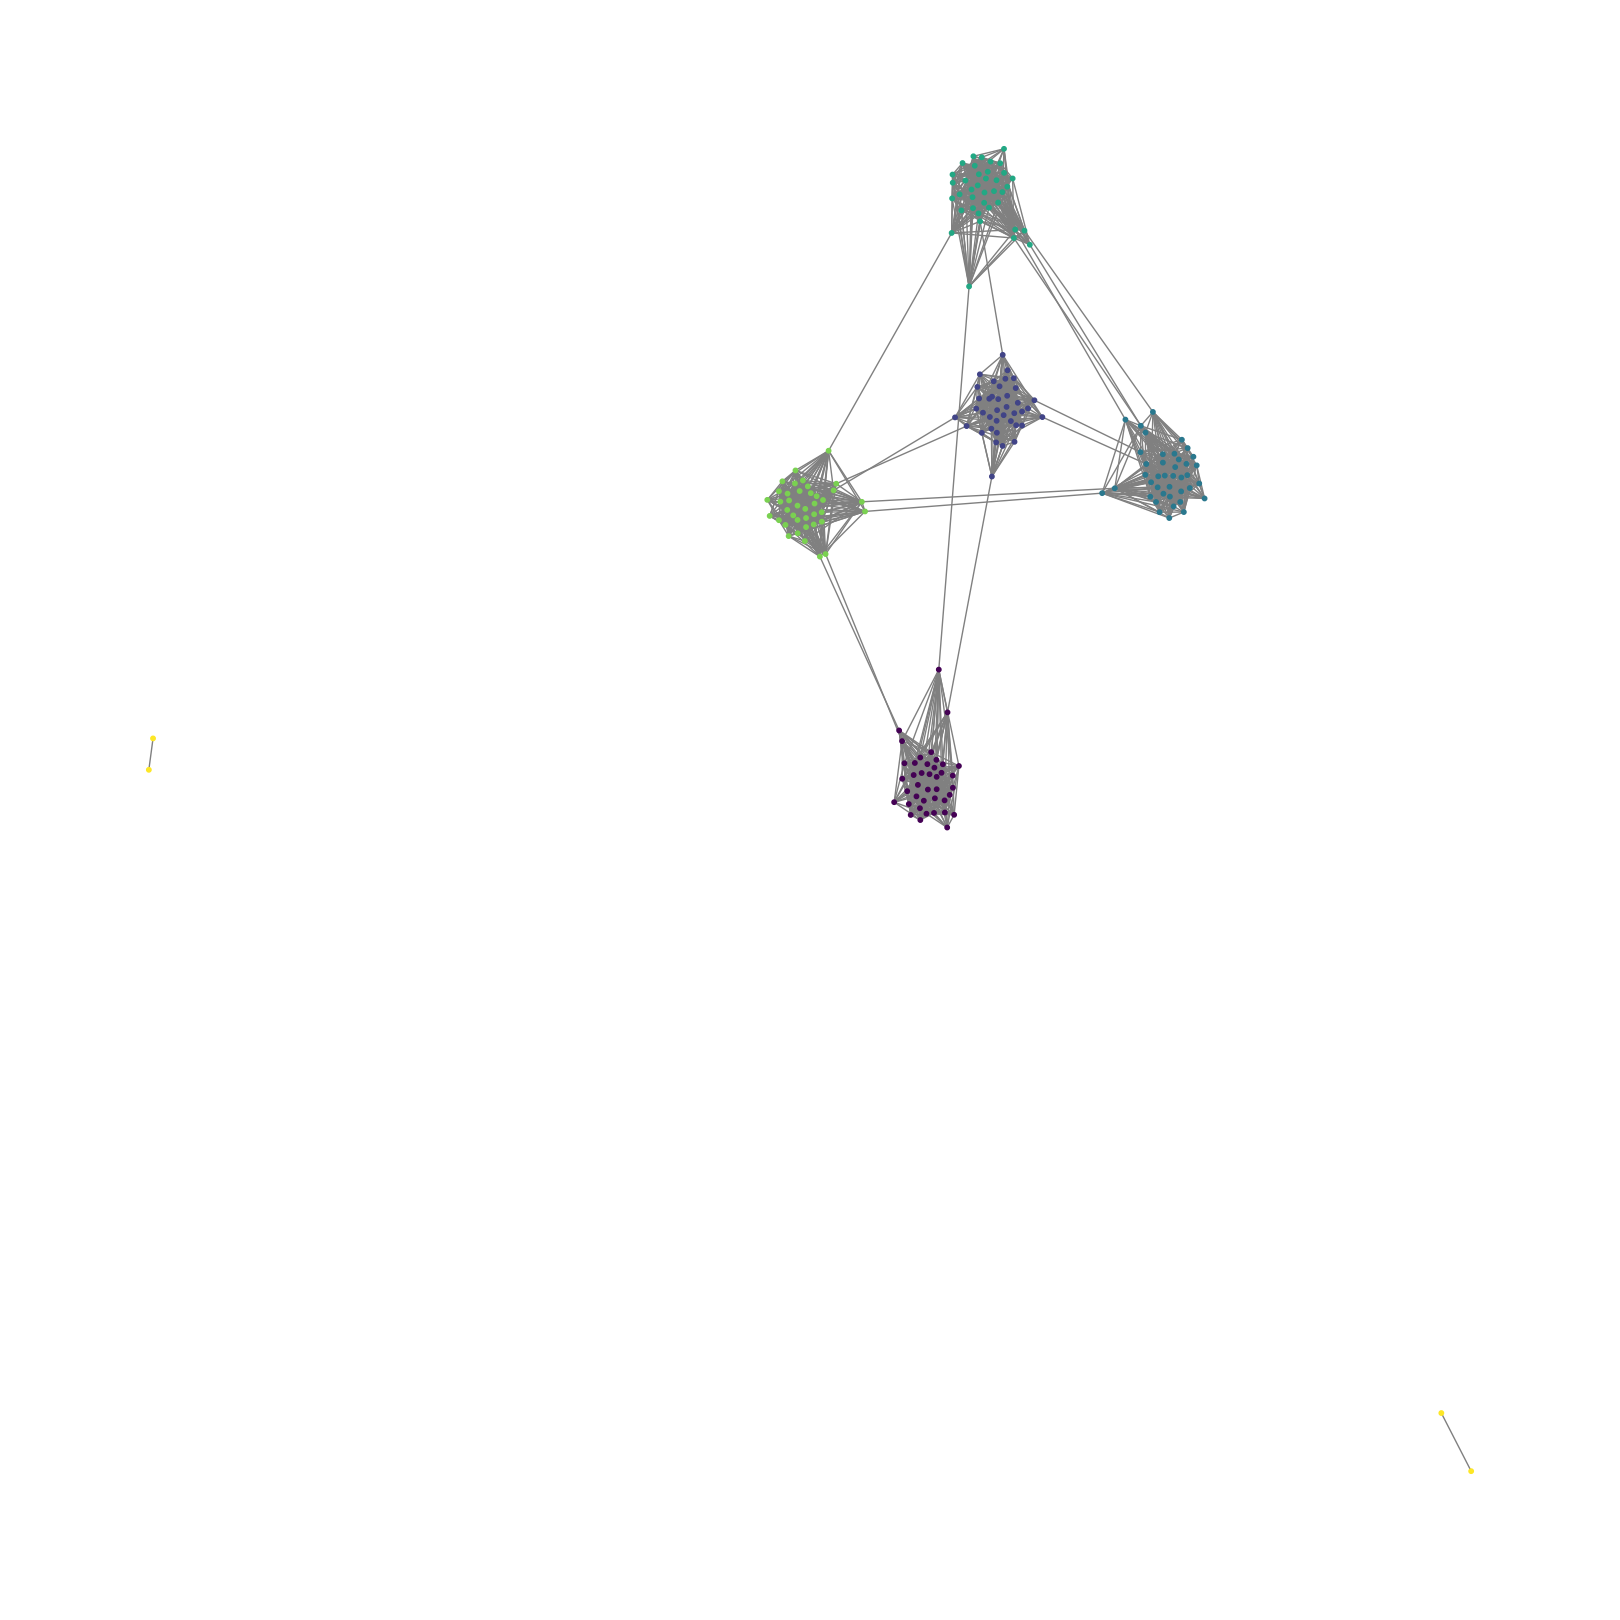

In [ ]:
# Generate synthetic graph with community structure
graph = nx.gaussian_random_partition_graph(
    n=200,
    s=40,
    v=40,
    p_in=0.5,
    p_out=0.001
)

# Extract ground-truth partition information
gt_partition = graph.graph["partition"]
node_groups = np.concatenate(
    [[idx] * len(nodes) for idx, nodes in enumerate(gt_partition)],
    axis=0
)

# Compute layout (copy used to avoid side effects)
layout_graph = graph.copy()
pos = nx.spring_layout(layout_graph, seed=17)
del layout_graph

# Visualization
plt.figure(figsize=(16,16))
nx.draw(
    graph,
    pos,
    node_color=node_groups,
    node_size=10,
    edge_color="gray"
)
plt.show()


In [ ]:
# Build sparse adjacency matrix from NetworkX graph
adjacency_sparse = sp.coo_matrix(nx.adjacency_matrix(graph))

# Create identity feature matrix (one-hot encoding per node)
identity_features = sp.eye(adjacency_sparse.shape[0], dtype=np.int64).tocoo()

# Convert sparse matrix to tuple representation
feat_indices, feat_values, feat_shape = convert_sparse_matrix(identity_features)


# Construct PyTorch sparse tensor
node_features = torch.sparse.FloatTensor(
    torch.LongTensor(feat_indices.T),
    torch.FloatTensor(feat_values),
    torch.Size(feat_shape)
)


/tmp/ipython-input-356956039.py:12: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:654.)
  node_features = torch.sparse.FloatTensor(


In [ ]:
def compute_louvain_partition(graph):
    partition = community_louvain.best_partition(
        graph,
        weight="weight"
    )
    return partition


louvain_partition = compute_louvain_partition(graph)

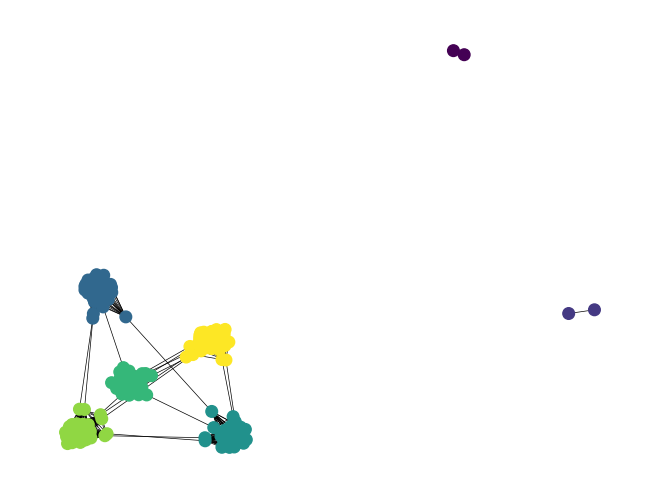

In [ ]:
def visualize_louvain(graph, partition):
    node_colors = [0] * len(partition)

    idx = 0
    for _, community_id in partition.items():
        node_colors[idx] = community_id
        idx += 1

    layout = nx.spring_layout(graph)
    nx.draw(
        graph,
        layout,
        with_labels=False,
        node_size=70,
        width=0.5,
        node_color=node_colors
    )
    plt.show()


visualize_louvain(graph, louvain_partition)

In [ ]:
def evaluate_clustering_results(cluster_assignments, true_labels, n_clusters=10):
    label_cluster_pairs = np.dstack([true_labels, cluster_assignments])[0]

    confusion_counts = np.zeros((n_clusters, n_clusters), dtype=int)
    for i in range(len(label_cluster_pairs)):
        confusion_counts[
            label_cluster_pairs[i][1],
            label_cluster_pairs[i][0]
        ] += 1

    cluster_to_label_map = list(map(lambda row: np.argmax(row), confusion_counts))
    confusion_counts = sorted(confusion_counts, key=lambda row: np.argmax(row))

    fig, ax = plt.subplots(1, figsize=(5, 5))
    heatmap = sn.heatmap(
        confusion_counts,
        annot=True,
        fmt="d",
        annot_kws={"size": 10},
        cmap="coolwarm",
        ax=ax,
        square=True,
        yticklabels=cluster_to_label_map
    )

    plt.xlabel("Actual")
    plt.ylabel("Cluster")
    heatmap.tick_params(length=0)
    heatmap.xaxis.tick_top()
    heatmap.xaxis.set_label_position("top")
    plt.title("Cluster match count for each number")

    # Purity calculation
    purity_counter = np.zeros((n_clusters, 1))

    for i in range(len(label_cluster_pairs)):
        if cluster_to_label_map[label_cluster_pairs[i][1]] == true_labels[i]:
            purity_counter[
                cluster_to_label_map[label_cluster_pairs[i][0]]
            ] += 1

    purity_score = np.add.reduce(purity_counter)[0] / len(true_labels)
    print("Purity", purity_score)

    plt.show()

In [ ]:
def run_kmeans_evaluation(latent_embeddings, true_labels, soft_assignments, n_clusters=7):
    kmeans_model = KMeans(n_clusters=n_clusters)

    z_cpu = latent_embeddings.cpu().detach()
    kmeans_model.fit(z_cpu)

    evaluate_clustering_results(
        kmeans_model.labels_,
        true_labels,
        n_clusters=n_clusters
    )

    evaluate_clustering_results(
        soft_assignments.argmax(axis=1).cpu().detach(),
        true_labels,
        n_clusters=n_clusters
    )

In [ ]:
def compute_accuracy(reconstructed_adj, true_adj):
    true_labels = true_adj.to_dense().view(-1).long()
    predicted_labels = (reconstructed_adj > 0.5).view(-1).long()
    return (predicted_labels == true_labels).sum().float() / true_labels.size(0)

In [ ]:
############################
# Vietoris–Rips filtration #
############################

def compute_wrcf_filtration(graph: nx.Graph, weight="weight"):
    """
    Compute the weight-rank clique filtration (WRCF) of a graph.

    :param graph: networkx Graph
    :param weight: edge weight attribute name
    :return: gudhi SimplexTree
    """
    simplex_tree = gd.SimplexTree()

    # Filtration step 0: insert all vertices
    for node in graph.nodes():
        simplex_tree.insert([node], filtration=0)

    # Sort unique edge weights (descending)
    ranked_weights = np.unique(
        [w for _, _, w in graph.edges.data(weight)]
    )[::-1]

    for _, threshold in enumerate(ranked_weights):
        # Threshold graph
        filtered_edges = [
            (u, v) for u, v, w in graph.edges.data(weight) if w >= threshold
        ]
        subgraph = graph.edge_subgraph(filtered_edges)

        # Insert maximal cliques
        for clique in nx.find_cliques(subgraph):
            # simplex_tree.insert(clique, filtration=_ + 1)  # thesis version
            simplex_tree.insert(clique, filtration=1 / threshold)

    return simplex_tree


def compute_wrcf_indices(adjacency_matrix, homology_dim, cardinality):
    """
    Parameters:
        adjacency_matrix : numpy array
        homology_dim     : homological dimension
        cardinality      : number of persistence pairs
    """

    simplex_tree = compute_wrcf_filtration(
      nx.from_numpy_array(adjacency_matrix)
    )

    _ = simplex_tree.persistence()
    persistence_pairs = simplex_tree.persistence_pairs()

    selected_indices = []
    persistence_values = []

    for birth_simplex, death_simplex in persistence_pairs:
        if len(birth_simplex) == homology_dim + 1 and len(death_simplex) > 0:
            birth_vertices = np.array(birth_simplex)
            death_vertices = np.array(death_simplex)

            birth_pair = np.unravel_index(
                np.argmax(adjacency_matrix[birth_vertices][:, birth_vertices]),
                (len(birth_simplex), len(birth_simplex))
            )
            death_pair = np.unravel_index(
                np.argmax(adjacency_matrix[death_vertices][:, death_vertices]),
                (len(death_simplex), len(death_simplex))
            )

            selected_indices += [birth_simplex[birth_pair[0]], birth_simplex[birth_pair[1]]]
            selected_indices += [death_simplex[death_pair[0]], death_simplex[death_pair[1]]]

            persistence_values.append(
                simplex_tree.filtration(death_simplex)
                - simplex_tree.filtration(birth_simplex)
            )

    # Sort by persistence (distance to diagonal)
    order = np.argsort(persistence_values)
    selected_indices = (
        np.reshape(selected_indices, [-1, 4])[order][::-1].flatten().tolist()
    )

    # Pad if needed
    target_length = 4 * cardinality
    selected_indices = selected_indices[:target_length] + \
        [0] * max(0, target_length - len(selected_indices))

    return np.array(selected_indices, dtype=np.int32)


class WRCFLayer(torch.nn.Module):
    def __init__(self, dim=1, card=50):
        super(WRCFLayer, self).__init__()
        self.dim = dim
        self.card = card

    def forward(self, adjacency_tensor: torch.Tensor):
        homology_dim = self.dim
        cardinality = self.card

        with torch.no_grad():
            vertex_indices = torch.from_numpy(
                compute_wrcf_indices(
                    adjacency_tensor.cpu().numpy(),
                    homology_dim,
                    cardinality
                )
            )

        if homology_dim > 0:
            index_pairs = vertex_indices.view(2 * cardinality, 2).long()
            persistence_diagram = adjacency_tensor[
                index_pairs[:, 0], index_pairs[:, 1]
            ].view(cardinality, 2)
        else:
            index_pairs = vertex_indices.view(2 * cardinality, 2)[1::2].long()
            persistence_diagram = torch.cat(
                [
                    torch.zeros(cardinality, 1),
                    adjacency_tensor[
                        index_pairs[:, 0], index_pairs[:, 1]
                    ].view(cardinality, 1).float()
                ],
                dim=1
            )

        return persistence_diagram

In [ ]:
class WrcfGAE(torch.nn.Module):
    def __init__(self, adjacency_sparse, gae_model, ground_truth) -> None:
        super().__init__()

        # GAE model (frozen / CPU for topology)
        self.gae = gae_model.cpu()

        # WRCF layer
        self.wrcf = WRCFLayer(dim=0, card=20)

        # Sparse adjacency (scipy COO)
        self.adjacency_sparse = adjacency_sparse

        # Ground-truth persistence diagram
        self.Q = None
        self.dgm_gt = self.wrcf(
            self.build_community_graph(*ground_truth)
        )

    @staticmethod
    def soft_argmax(x, dim, beta=1e2):
        # crude: assumes max value is unique
        scaled = beta * x
        probs = torch.nn.functional.softmax(scaled, dim=dim)
        indices = torch.arange(x.size(dim), device=x.device)
        weighted = indices * probs
        return torch.sum(weighted, dim=dim)

    def build_community_graph(self, soft_assignments: torch.Tensor, adjacency_sparse):
        """
        soft_assignments : (N × K) indicator matrix
        adjacency_sparse : scipy.sparse COO adjacency
        """
        # Hard assignment
        indicator = torch.argmax(soft_assignments, dim=1)

        indicator_hat = torch.stack(
            [
                torch.where(indicator == k, 1.0, 0.0)
                for k in range(soft_assignments.size(1))
            ]
        ).T

        Q_hat = indicator_hat * soft_assignments

        W_dense = torch.tensor(
            adjacency_sparse.todense(),
            dtype=torch.float
        )

        community_graph = torch.mm(
            torch.mm(Q_hat.T, W_dense),
            Q_hat
        ).fill_diagonal_(0)

        # Normalization
        community_graph = community_graph / W_dense.sum()

        return community_graph

    def forward(self, node_features, epoch, adj_label, weight_tensor, norm):

        reconstructed_adj, latent_embeddings, soft_assignments = self.gae(
            node_features, epoch + args.start_mf + 1
        )

        reconstruction_loss = norm * F.binary_cross_entropy(
            reconstructed_adj.view(-1),
            adj_label.to_dense().view(-1),
            weight=weight_tensor
        )

        mse_loss = torch.nn.MSELoss()
        clustering_loss = mse_loss(
            latent_embeddings,
            torch.mm(soft_assignments, self.gae.centroids)
        )

        # Topological loss via WRCF
        community_graph = self.build_community_graph(
            soft_assignments,
            self.adjacency_sparse
        )

        dgm_community = self.wrcf(community_graph)

        wasserstein_dist = wasserstein_distance(
            self.dgm_gt.detach().numpy(),
            dgm_community.detach().numpy(),
            order=1,
            internal_p=2
        )
        topological_loss = torch.tensor(wasserstein_dist, dtype=torch.float)

        total_loss = reconstruction_loss + clustering_loss + topological_loss

        return total_loss, reconstructed_adj, latent_embeddings, soft_assignments

In [ ]:
def train_model(node_features, adjacency_sparse):
    # Normalize adjacency
    adj_norm_tuple = normalize_adjacency(adjacency_sparse)
    adj_label_tuple = convert_sparse_matrix(adjacency_sparse)

    adj_norm = torch.sparse.FloatTensor(
        torch.LongTensor(adj_norm_tuple[0].T),
        torch.FloatTensor(adj_norm_tuple[1]),
        torch.Size(adj_norm_tuple[2])
    )

    adj_label = torch.sparse.FloatTensor(
        torch.LongTensor(adj_label_tuple[0].T),
        torch.FloatTensor(adj_label_tuple[1]),
        torch.Size(adj_label_tuple[2])
    )

    # Class imbalance handling
    positive_weight = float(
        adjacency_sparse.shape[0] * adjacency_sparse.shape[0] - adjacency_sparse.sum()
    ) / adjacency_sparse.sum()

    normalization_factor = (
        adjacency_sparse.shape[0] * adjacency_sparse.shape[0] /
        float((adjacency_sparse.shape[0] * adjacency_sparse.shape[0] - adjacency_sparse.sum()) * 2)
    )

    label_mask = adj_label.to_dense().view(-1) == 1
    loss_weights = torch.ones(label_mask.size(0))
    loss_weights[label_mask] = positive_weight

    # Convert node_groups to one-hot encoding for ground truth soft assignments
    num_nodes = len(node_groups)
    num_clusters = args.n_cluster # This should be correctly set by the calling cell
    one_hot_node_groups = torch.zeros(num_nodes, num_clusters)
    one_hot_node_groups[torch.arange(num_nodes), torch.tensor(node_groups)] = 1.0

    # Initialize model
    gae_model = GraphAutoEncoder(adj_norm)
    model = WrcfGAE(adjacency_sparse, gae_model, (one_hot_node_groups, adjacency_sparse))
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    # Training loop
    for epoch_idx in range(args.num_epoch):
        start_time = time.time()

        total_loss, reconstructed_adj, latent_embeddings, soft_assignments = model(
            node_features, epoch_idx, adj_label, loss_weights, normalization_factor
        )

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        train_accuracy = compute_accuracy(reconstructed_adj, adj_label)

        print(
            "Epoch:", f"{epoch_idx + 1:04d}",
            "train_loss=", f"{total_loss.item():.5f}",
            "train_acc=", f"{train_accuracy:.5f}",
            "time=", f"{time.time() - start_time:.5f}"
        )

    run_kmeans_evaluation(
        latent_embeddings,
        true_labels=clusters,
        soft_assignments=soft_assignments,
        n_clusters=args.n_cluster
    )

    return model

Epoch: 0001 train_loss= 0.69466 train_acc= 0.09305 time= 0.02841
Epoch: 0002 train_loss= 0.63373 train_acc= 0.09780 time= 0.02555
Epoch: 0003 train_loss= 0.59646 train_acc= 0.19710 time= 0.01829
Epoch: 0004 train_loss= 0.57917 train_acc= 0.35715 time= 0.01470
Epoch: 0005 train_loss= 0.56988 train_acc= 0.48800 time= 0.01486
Epoch: 0006 train_loss= 0.56256 train_acc= 0.61330 time= 0.01551
Epoch: 0007 train_loss= 0.55886 train_acc= 0.73730 time= 0.01530
Epoch: 0008 train_loss= 0.55640 train_acc= 0.81650 time= 0.01450
Epoch: 0009 train_loss= 0.55482 train_acc= 0.84645 time= 0.01586
Epoch: 0010 train_loss= 0.55369 train_acc= 0.85980 time= 0.01563
Epoch: 0011 train_loss= 0.55287 train_acc= 0.86960 time= 0.01746
Epoch: 0012 train_loss= 0.55136 train_acc= 0.87080 time= 0.01577
Epoch: 0013 train_loss= 0.55091 train_acc= 0.87150 time= 0.01490
Epoch: 0014 train_loss= 0.55032 train_acc= 0.87570 time= 0.01737
Epoch: 0015 train_loss= 0.55012 train_acc= 0.87980 time= 0.01446
Epoch: 0016 train_loss= 0

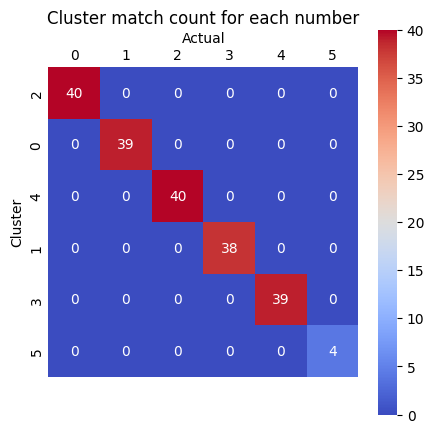

Purity 0.98


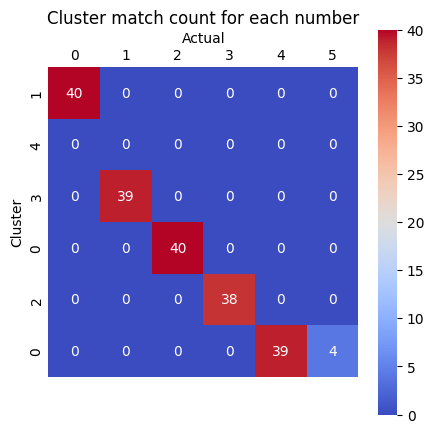

In [ ]:
args.n_cluster = len(np.unique(node_groups))
clusters = node_groups
model = train_model(node_features, adjacency_sparse)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


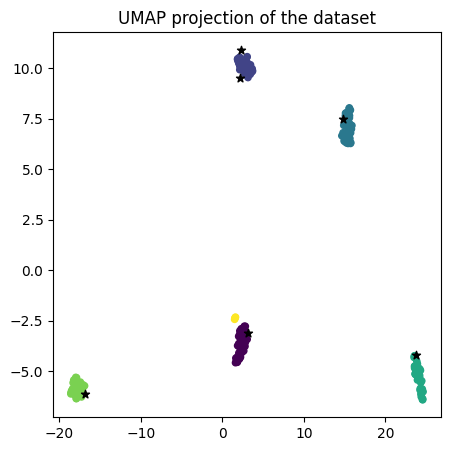

In [ ]:
model.eval()

# Recompute adj_label, positive_weight, normalization_factor (norm), and weight_tensor
adj_label_tuple = convert_sparse_matrix(adjacency_sparse)
adj_label = torch.sparse.FloatTensor(
    torch.LongTensor(adj_label_tuple[0].T),
    torch.FloatTensor(adj_label_tuple[1]),
    torch.Size(adj_label_tuple[2])
)

positive_weight = float(
    adjacency_sparse.shape[0] * adjacency_sparse.shape[0] - adjacency_sparse.sum()
) / adjacency_sparse.sum()

norm = (
    adjacency_sparse.shape[0] * adjacency_sparse.shape[0] /
    float((adjacency_sparse.shape[0] * adjacency_sparse.shape[0] - adjacency_sparse.sum()) * 2)
)

label_mask = adj_label.to_dense().view(-1) == 1
weight_tensor = torch.ones(label_mask.size(0))
weight_tensor[label_mask] = positive_weight

# Pass all required arguments to the model's forward method
_, _, latent_embeddings, soft_assignments = model(
    node_features,
    500, # Using 500 for epoch as it was in the original call
    adj_label,
    weight_tensor,
    norm
)

encoded = latent_embeddings.cpu().detach().numpy()
centroids = model.gae.centroids.cpu().detach().numpy()

visualize_umap(
    0,
    encoded,
    point_color=clusters,
    cluster_centers=centroids
)

# visualize_tsne(0, encoded, color=true_labels, centroids=centroids)
# visualize_tsne(0, encoded, color=soft_assignments.argmax(axis=1), centroids=centroids)

In [ ]:
soft_assignments

tensor([[0.0000, 0.1723, 0.1086, 0.4896, 0.0397, 0.1898],
        [0.0000, 0.1678, 0.1074, 0.4892, 0.0456, 0.1900],
        [0.0000, 0.1663, 0.1095, 0.4918, 0.0420, 0.1905],
        ...,
        [0.0022, 0.3321, 0.2949, 0.0971, 0.2736, 0.0000],
        [0.0022, 0.3321, 0.2949, 0.0971, 0.2736, 0.0000],
        [0.0031, 0.3275, 0.2968, 0.0977, 0.2749, 0.0000]],
       grad_fn=<DivBackward0>)

In [ ]:
model_copy=copy.deepcopy(model)

In [ ]:
model_copy

WrcfGAE(
  (gae): GraphAutoEncoder(
    (encoder_layer): SparseGraphConvolution()
  )
  (wrcf): WRCFLayer()
)

In [ ]:
def retrain_with_topo(gae_model, ground_truth, adjacency_sparse, node_features):
    # Normalize adjacency
    adj_norm_tuple = normalize_adjacency(adjacency_sparse)
    adj_label_tuple = convert_sparse_matrix(adjacency_sparse)

    adj_norm = torch.sparse.FloatTensor(
        torch.LongTensor(adj_norm_tuple[0].T),
        torch.FloatTensor(adj_norm_tuple[1]),
        torch.Size(adj_norm_tuple[2])
    ).cpu()

    adj_label = torch.sparse.FloatTensor(
        torch.LongTensor(adj_label_tuple[0].T),
        torch.FloatTensor(adj_label_tuple[1]),
        torch.Size(adj_label_tuple[2])
    ).cpu()

    # Class imbalance handling
    pos_weight = float(
        adjacency_sparse.shape[0] * adjacency_sparse.shape[0] - adjacency_sparse.sum()
    ) / adjacency_sparse.sum()

    norm = (
        adjacency_sparse.shape[0] * adjacency_sparse.shape[0] /
        float((adjacency_sparse.shape[0] * adjacency_sparse.shape[0] - adjacency_sparse.sum()) * 2)
    )

    weight_mask = adj_label.to_dense().view(-1) == 1
    weight_tensor = torch.ones(weight_mask.size(0))
    weight_tensor[weight_mask] = pos_weight

    # === TOPO TRAINING WRAPPER ===
    topo_trainer = WrcfGAE(
        adjacency_sparse=adjacency_sparse,
        gae_model=gae_model,
        ground_truth=ground_truth
    )

    optimizer = torch.optim.Adam(topo_trainer.parameters(), lr=0.01)

    for epoch in range(100):
        optimizer.zero_grad()

        total_loss, _, _, _ = topo_trainer(
            node_features.cpu(),
            epoch,
            adj_label,
            weight_tensor,
            norm
        )

        total_loss.backward()
        optimizer.step()

    # 🔑 CRITICAL FIX:
    # Return the INNER GraphAutoEncoder, not WrcfGAE
    return topo_trainer.gae


In [ ]:
# IMPORTANT: copy the *GraphAutoEncoder*, not WrcfGAE
model2 = copy.deepcopy(model.gae)

# Ground-truth soft assignments (computed from GAE)
with torch.no_grad():
    _, latent_gt, soft_assignments_gt = model2(node_features, 1000)

ground_truth = (soft_assignments_gt, adjacency_sparse)

# Topology-aware retraining
model2 = retrain_with_topo(
    gae_model=model2,                  # <-- GraphAutoEncoder ONLY
    ground_truth=ground_truth,
    adjacency_sparse=adjacency_sparse,
    node_features=node_features
)



/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Figure size 1000x1000 with 0 Axes>

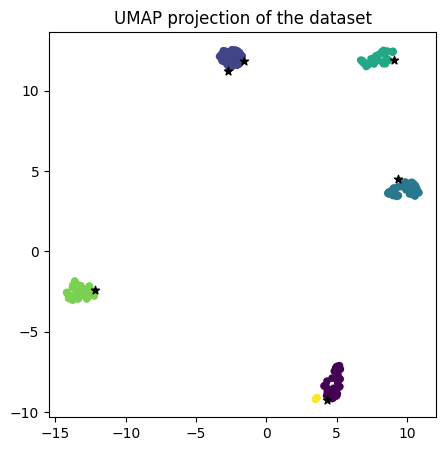

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


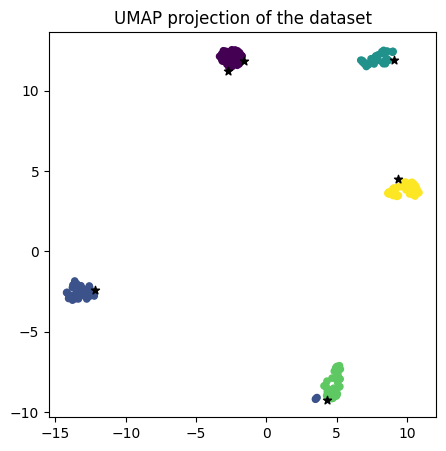

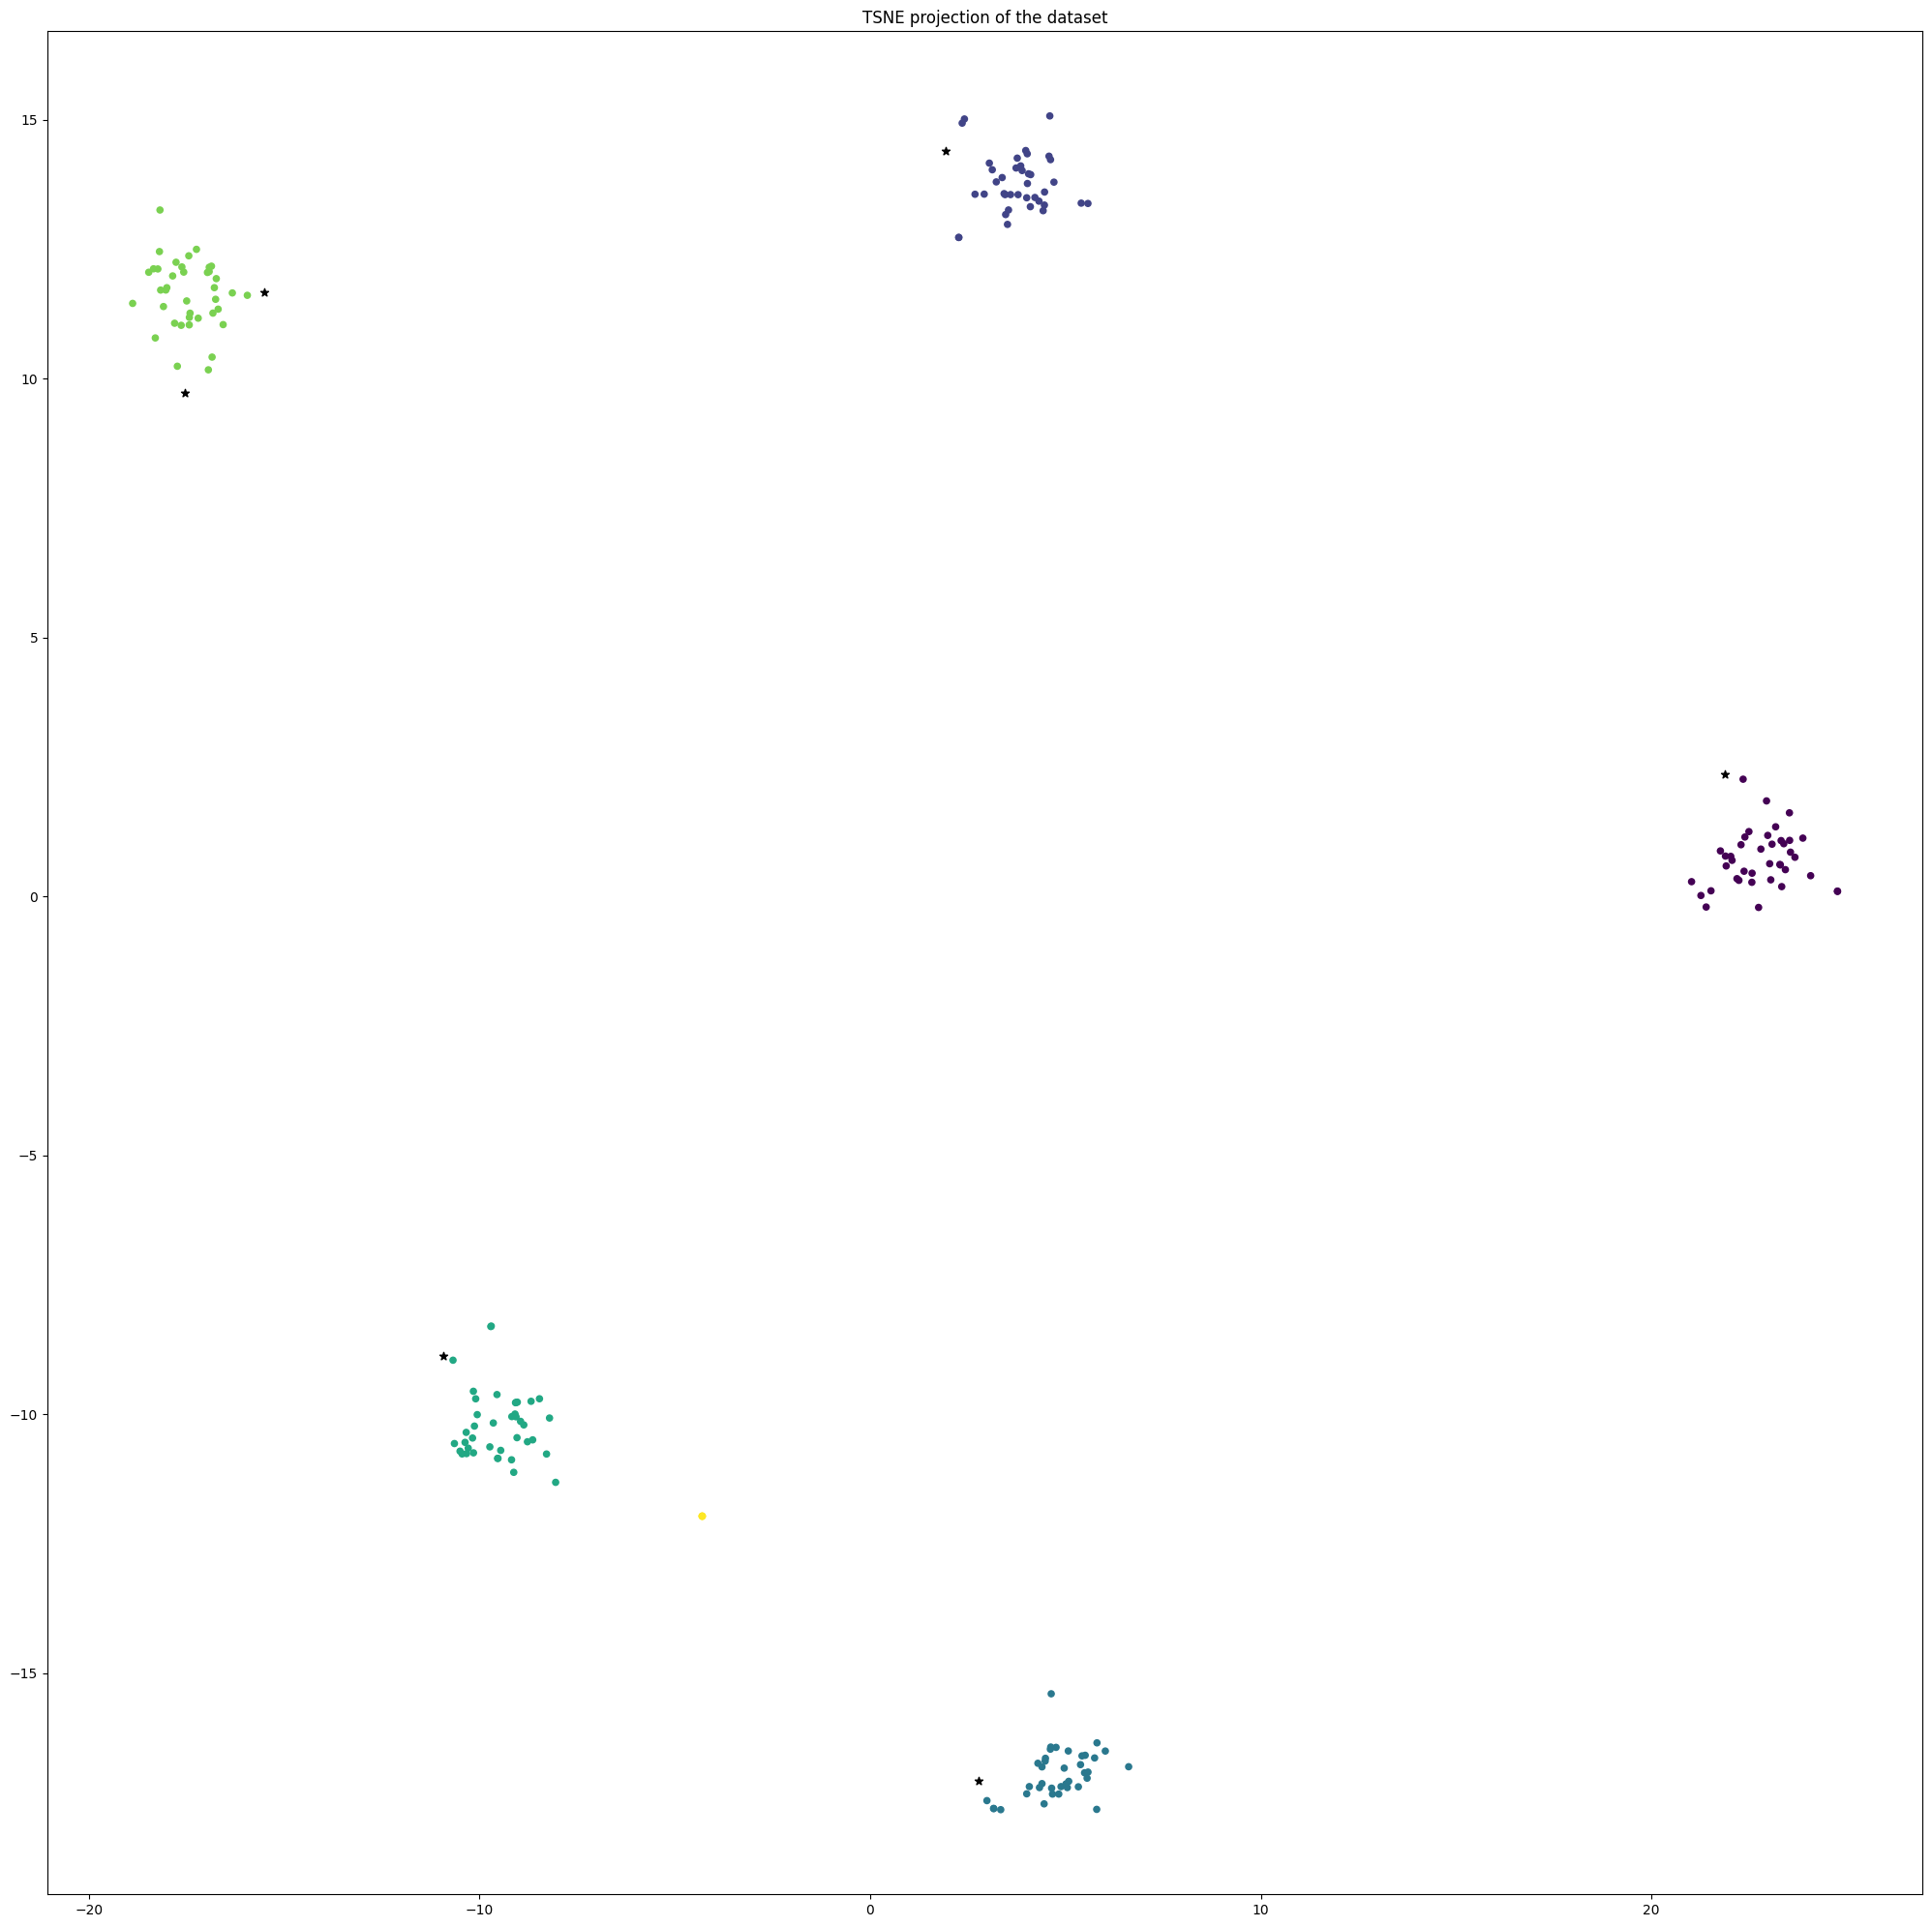

In [ ]:
plt.figure(figsize=(10, 10))
model2.eval()

with torch.no_grad():
    _, latent_embeddings, soft_assignments = model2(node_features, 1000)

encoded = latent_embeddings.cpu().detach().numpy()
centroids = model2.centroids.cpu().detach().numpy()

predicted_clusters = soft_assignments.argmax(dim=1).cpu().detach().numpy()

# UMAP with ground-truth communities
visualize_umap(
    0,
    encoded,
    point_color=clusters,
    cluster_centers=centroids
)

# UMAP with predicted clusters
visualize_umap(
    0,
    encoded,
    point_color=predicted_clusters,
    cluster_centers=centroids
)

# t-SNE with KMeans on latent space
kmeans_model = KMeans(n_clusters=args.n_cluster)
kmeans_model.fit(encoded)

visualize_tsne(
    0,
    encoded,
    point_color=kmeans_model.labels_,
    cluster_centers=centroids
)


Purity 1.0


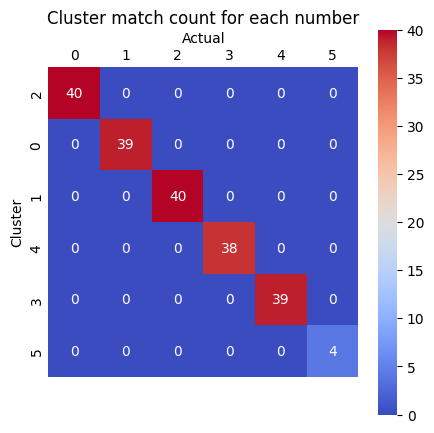

Purity 0.98


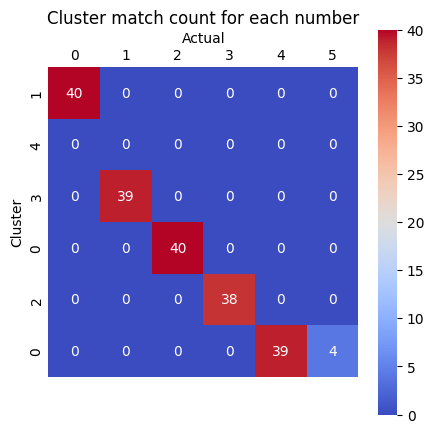

In [ ]:
run_kmeans_evaluation(
    latent_embeddings,
    true_labels=clusters,
    soft_assignments=soft_assignments,
    n_clusters=args.n_cluster
)